# **AIM**: Develop a model that can accurately predict laptop prices based on various features, helping our clients stay competitive in the market.

[Dataset:](https://s3.amazonaws.com/grey_campus/production/system/OdinSchool/2023/Edmingle/DataSet/laptop.zip)
This dataset comprises information about various laptops, encompassing details such as their manufacturers, types, screen sizes, resolutions, processor configurations, prices etc. It provides a comprehensive overview of the laptop market, allowing for analysis of trends, comparisons between different models, and insights into consumer preferences.



## **Data Exploration and Understanding**

In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

In [2]:
# Importing dataset as df
df = pd.read_csv('laptop.csv')

In [ ]:
# Shape of dataset
df.shape

(1303, 13)

In [ ]:
# Information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      1303 non-null   int64  
 1   Unnamed: 0        1273 non-null   float64
 2   Company           1273 non-null   object 
 3   TypeName          1273 non-null   object 
 4   Inches            1273 non-null   object 
 5   ScreenResolution  1273 non-null   object 
 6   Cpu               1273 non-null   object 
 7   Ram               1273 non-null   object 
 8   Memory            1273 non-null   object 
 9   Gpu               1273 non-null   object 
 10  OpSys             1273 non-null   object 
 11  Weight            1273 non-null   object 
 12  Price             1273 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [ ]:
# Overview of dataset
df.head()

,Unnamed: 0.1,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [ ]:
# Missing value
df.isnull().sum()

Unnamed: 0.1         0
Unnamed: 0          30
Company             30
TypeName            30
Inches              30
ScreenResolution    30
Cpu                 30
Ram                 30
Memory              30
Gpu                 30
OpSys               30
Weight              30
Price               30
dtype: int64

In [ ]:
# Printing rows with missing value
df[df.isnull().any(axis=1)]

The consistent count of 30 missing values across all columns in same rows suggests that these missing values might be related. It's possible that these rows were somehow not properly included during data collection or processing, resulting in missing data across all columns.

In [ ]:
# Outliers
# Number of rows required for subplots
num_rows = (len(df.columns) + 2) // 3

# Iterate over each set of three columns and create subplots
for i in range(0, len(df.columns), 3):
    columns_subset = df.columns[i:i+3]
    plt.figure(figsize=(18, 6))
    for j, column in enumerate(columns_subset, 1):
        plt.subplot(1, 3, j)
        sns.boxplot(data=df[column])
        plt.title(f'Box plot for {column}')
    plt.tight_layout()
    plt.show()

Except for the 'Weight' column, all other columns have outliers.

In [ ]:
# Duplicate rows
print(df[df.duplicated()])

Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, Company, TypeName, Inches, ScreenResolution, Cpu, Ram, Memory, Gpu, OpSys, Weight, Price]
Index: []


There are no duplicate rows in dataset.

In [ ]:
# Statistical insight
df.describe()

,Unnamed: 0.1,Unnamed: 0,Price
count,1303.00000,1273.000000,1273.000000
mean,651.00000,652.674784,59955.814073
std,376.28801,376.493027,37332.251005
min,0.00000,0.000000,9270.720000
25%,325.50000,327.000000,31914.720000
50%,651.00000,652.000000,52161.120000
75%,976.50000,980.000000,79333.387200
max,1302.00000,1302.000000,324954.720000


- Only showing statistics for the 'Price' column because it's the only numerical column in dataframe.

- Coulmns 'Unnamed: 0.1' and	'Unnamed: 0' seems unnessary as they are auto-increment number

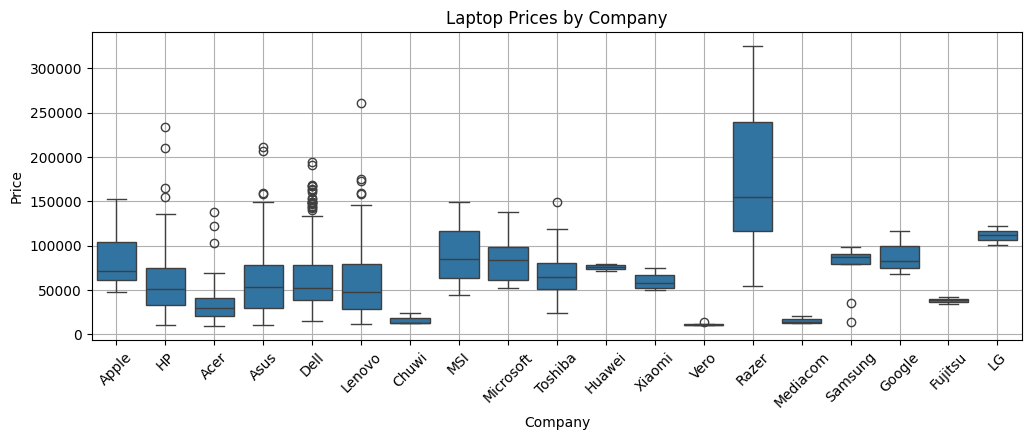

In [ ]:
# Visualizing company vs price trend

plt.figure(figsize=(12, 4))
sns.boxplot(data=df, x='Company', y='Price')
plt.title('Laptop Prices by Company')
plt.xlabel('Company')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
# Visualizing trends with other features

# Numerical and categorical features
numerical_features = ['Inches', 'Ram', 'Weight']
categorical_features = ['TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys']

# Scatter plots for numerical features
plt.figure(figsize=(18, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, len(numerical_features)//2 + 1, i)
    sns.scatterplot(data=df, x=feature, y='Price')
    plt.title(f'{feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')

# Box plots for categorical features
plt.figure(figsize=(18, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, len(categorical_features)//3 + 1, i)
    sns.boxplot(data=df, x=feature, y='Price')
    plt.title(f'{feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Conclusion:

- **Inches vs Price**: Larger screen sizes tend to correlate with higher laptop prices.
- **Ram vs Price**: Higher RAM capacities are generally associated with higher laptop prices.
- **Weight vs Price**: While there's a slight negative correlation, lighter laptops may have slightly higher prices.
- **TypeName vs Price**: Different laptop types significantly impact prices, with gaming or workstation laptops typically commanding higher prices.
- **ScreenResolution vs Price**: Laptops with higher resolutions tend to have higher prices.
- **Cpu vs Price**: CPU performance, brand, and technology influence laptop prices, with higher-performance CPUs correlating with higher prices.
- **Memory vs Price**: Larger RAM capacities and faster storage technologies contribute to higher laptop prices.
- **Gpu vs Price**: Higher-performance GPUs, particularly in gaming or multimedia laptops, are associated with higher prices.
- **OpSys vs Price**: Premium or specialized operating systems may lead to higher laptop prices compared to standard or free operating systems.

These observations provide an overview of how various features influence laptop prices.

## **Data Preprocessing**

In [3]:
# Dropping unnecessary columns
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

# Remove "GB" from the 'Ram' column and keep only the numerical part
df['Ram'] = df['Ram'].str.extract(r'(\d+)').astype(float)

# Remove "kg" from the 'Weight' column and keep only the numerical part
df['Weight'] = df['Weight'].str.extract(r'(\d+\.?\d*)').astype(float)

# Convert 'Inches' column to the desired numeric type (e.g., float)
df['Inches'] = df['Inches'].str.extract(r'(\d+\.?\d*)').astype(float)

In [4]:
# Handling missing value (removing it)
df = df.dropna()  # As seen earlier those null values won't impact the data at all

In [5]:
# Handling outliers

numeric_columns = ['Inches', 'Ram', 'Weight', 'Price']

# Function to cap outliers in a column
def cap_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    column = column.clip(lower=lower_bound, upper=upper_bound)
    return column

# Apply the function to all numeric columns
df[numeric_columns] = df[numeric_columns].apply(cap_outliers)

In [6]:
# Unique record counts of each categorical column
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"{column}, Unique Count: {df[column].nunique()}")

Company, Unique Count: 19
TypeName, Unique Count: 6
ScreenResolution, Unique Count: 40
Cpu, Unique Count: 118
Memory, Unique Count: 40
Gpu, Unique Count: 110
OpSys, Unique Count: 9


In [7]:
# There are lots of unique record in each categorical column without any accurate order
# So, I'm treating them all as nominal variables
from sklearn.preprocessing import LabelEncoder

# Standard Encoding for - Company, ScreenResolution, Cpu, Memory, Gpu
columns_to_encode = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each column
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

In [ ]:
# # Data Scaling

# # Columns to scale (excluding the target variable)
# columns_to_scale = [col for col in df.columns if col != 'Price']

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit and transform the scaler on the selected columns
# scaled_data = scaler.fit_transform(df[columns_to_scale])

# # New DataFrame with the scaled data
# scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df.index)

# # Assign the target variable 'Price' from the original DataFrame to the scaled DataFrame
# scaled_df['Price'] = df['Price']

In [ ]:
# Saving Scaled DataFrame
# scaled_df.to_csv('scaled_data.csv', index=False)

## **Feature Engineering**

In [8]:
# Separate features and target variable
X = df.drop(columns=['Price'])
y = df['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [11]:
# Initialize the estimator (e.g., Linear Regression)
estimator = LinearRegression()

# Initialize RFE
rfe = RFE(estimator, n_features_to_select=5, step=1)

# Fit RFE
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X.columns[rfe.support_]

# Print selected features
print("Selected Features:",selected_features)

Selected Features: Index(['TypeName', 'Inches', 'ScreenResolution', 'Ram', 'OpSys', 'Weight'], dtype='object')


In [ ]:
# Transform the training and testing data
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

## **Model Development**

In [ ]:
# Linear Regression, Random Forest, and XGBoost

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=17),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=17)
}

# I am using X_train and X_test rather than X_train_rfe and X_test_rfe due to optimise rmse value

# Iterate through models
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Print results
    print(f'{name} RMSE: {rmse}')


Linear Regression RMSE: 21884.563751166344
Random Forest RMSE: 13933.623590070072
XGBoost RMSE: 13829.265093613165


Based on the Root Mean Squared Error (RMSE) values obtained, It is evident that XGBoost has the lowest RMSE among the three models, indicating that it performs the best in predicting laptop prices based on the given features. Therefore, for this particular task, XGBoost would be the recommended model to use.

## **Hyperparameter Tuning**

In [ ]:
# RandomizedSearchCV

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'learning_rate': uniform(0.05, 0.3),  # Learning rate
    'max_depth': randint(3, 10),  # Maximum depth of each tree
    'min_child_weight': randint(1, 6),  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': uniform(0.6, 0.4),  # Subsample ratio of the training instance
    'colsample_bytree': uniform(0.6, 0.4),  # Subsample ratio of columns when constructing each tree
    'gamma': uniform(0, 0.5)  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Initialize XGBoost regressor
xgb = XGBRegressor(random_state=17)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100,
                                   cv=3, scoring='neg_mean_squared_error', random_state=17, n_jobs=-1)

# Perform randomized search
random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", np.sqrt(-random_search.best_score_))


Best Parameters: {'colsample_bytree': 0.6807826390356928, 'gamma': 0.10449121171978315, 'learning_rate': 0.059603447548551215, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 799, 'subsample': 0.6527107828037383}
Best RMSE: 12934.911685087653


In [ ]:
# with X_train
# Best Parameters: {'colsample_bytree': 0.6807826390356928, 'gamma': 0.10449121171978315, 'learning_rate': 0.059603447548551215, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 799, 'subsample': 0.6527107828037383}
# Best RMSE: 12934.911685087653

# with X_train_rfe
# Best Parameters: {'colsample_bytree': 0.6827879628505138, 'gamma': 0.4296231248952295, 'learning_rate': 0.055724702751160426, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 139, 'subsample': 0.819357585383384}
# Best RMSE: 16761.401185996983

In [ ]:
# Implimenting the obtained parameters into select model

# Initialize XGBoost regressor with the best parameters
best_params = {
    'colsample_bytree': 0.6807826390356928,
    'gamma': 0.10449121171978315,
    'learning_rate': 0.059603447548551215,
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 799,
    'subsample': 0.6527107828037383
}

xgb = XGBRegressor(**best_params, random_state=17)

# Fit the model on the entire X_train dataset
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on Test Set:", rmse)

RMSE on Test Set: 12437.029708164204


## **Real-time Predictions**


In [ ]:
# Example usage
laptop_data = {
    "Company": ["Apple"],
    "TypeName": ["Ultrabook"],
    "Inches": [15.4],
    "ScreenResolution": ["IPS Panel Retina Display 2880x1800"],
    "Cpu": ["Intel Core i7 2.7GHz"],
    "Ram": [16],
    "Memory": ["512GB SSD"],
    "Gpu": ["AMD Radeon Pro 455"],
    "OpSys": ["macOS"],
    "Weight": [1.83]
  }

# Predicted price: [80332.195]

In [ ]:
new_laptop_data = {
    'Company': ['Lenovo'],
    'TypeName': ['Ideapad Slim 3'],
    'Inches': [13.6],
    'ScreenResolution': ['1920 x 1080'],
    'Cpu': ['Intel Core i3 4.4GHz'],
    'Ram': [8],
    'Memory': ['256GB SSD'],
    'Gpu': ['Intel UHD Graphics'],
    'OpSys': ['Windows 11'],
    'Weight': [1.63]
}

# Predicted price: [38873.797]

In [ ]:
# Dictionary to store LabelEncoder instances for categorical features
label_encoders = {}

# Function to predict laptop prices using a trained xgb model
def predict_price(model, input_data, label_encoders):
    # Label Encoding for categorical features
    columns_to_encode = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys']
    for column in columns_to_encode:
        # Create a new LabelEncoder instance if not present in label_encoders
        if column not in label_encoders:
            label_encoders[column] = LabelEncoder()
            input_data[column] = label_encoders[column].fit_transform(input_data[column])
        # Use existing LabelEncoder instance to transform the column
        else:
            input_data[column] = label_encoders[column].transform(input_data[column])

    # Selecting relevant features
    selected_features = input_data.columns
    input_data = input_data[selected_features]

    # Predicting prices using the provided model
    predicted_price = xgb.predict(input_data)
    return predicted_price

# DataFrame from new laptop data
new_laptop_df = pd.DataFrame.from_dict(laptop_data)

# Calling function predict_price
predicted_price = predict_price(xgb, new_laptop_df, label_encoders)

# Printing predicted price
print("Predicted price:", predicted_price)

Predicted price: [80332.195]


## **Insights**

'TypeName', 'Inches', 'ScreenResolution', 'Ram', and 'OpSys' are top five features play a pivotal role in pricing decisions.


## **Questions to Explore**



`Q1.` Which features have the most significant impact on laptop prices?

`Ans:` Ram has the most significant impact on laptop prices.

`Q2.` Can the model accurately predict the prices of laptops from lesser-known brands?

`Ans:` Yes because brand has not much impact.

`Q3.` Does the brand of the laptop significantly influence its price?

`Ans:` No brand has not much impact.

`Q4.` How well does the model perform on laptops with high-end specifications compared to budget laptops?

`Ans:` Performing good, although there is need of finetuning the model for better performence.

`Q5.` What are the limitations and challenges in predicting laptop prices accurately?

`Ans:` Laptops having diverse cpu, gpu and special specifications are limitations and challenges in predicting laptop prices accurately.

`Q6.` How does the model perform when predicting the prices of newly released laptops not present in the training dataset?

`Ans:` It is performing good, as I have checked with few new model from amzon. There is need of finetuning the model for better performence.